# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import math

# Episodic Semi-gradient Sarsa

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 244, 10.1 Episodic Semi-gradient Control

In [55]:
class MountainCarEnv:
    def __init__(self, max_steps, tiles, action_velocity=0.001, successful_finish_reward=0):
        self.pos = 0
        self.vel = 0
        self.max_steps = max_steps
        self.steps_left = max_steps
        self.successful_finish_reward = successful_finish_reward
        self.action_velocity = action_velocity
        self.tiles = tiles

        self.BOUNDARY_START_POS = [-0.6, -0.4]
        self.BOUNDARY_POS = [-1.2, 0.5]
        self.BOUNDARY_VEL = [-0.07, 0.07]

    def _tile_state(self):
        pos = self.pos
        vel = self.vel
        T = self.tiles

        dpos = (self.BOUNDARY_POS[1] - self.BOUNDARY_POS[0]) / T
        pos_i = np.clip(int(math.floor((pos - self.BOUNDARY_POS[0]) / dpos)), 0, T - 1)

        dvel = (self.BOUNDARY_VEL[1] - self.BOUNDARY_VEL[0]) / T
        vel_i = np.clip(int(math.floor((vel - self.BOUNDARY_VEL[0]) / dvel)), 0, T - 1)

        state = np.zeros((T + T), dtype=np.int32)
        state[pos_i] = 1
        state[T + vel_i] = 1
        return state

    def reset(self):
        self.pos = self.BOUNDARY_START_POS[0] + np.random.rand() * (self.BOUNDARY_START_POS[1] - self.BOUNDARY_START_POS[0])
        self.vel = 0
        self.steps_left = self.max_steps
        return self._tile_state(), {}

    def step(self, action):
        assert 0 <= action <= 2   # Different from the book to make it more like gym environment
        assert self.steps_left > 0

        pos = self.pos
        vel = self.vel

        self.pos = np.clip(pos + vel, self.BOUNDARY_POS[0] - 0.1, self.BOUNDARY_POS[1] + 0.1)
        self.vel = np.clip(vel + self.action_velocity * (action - 1) - 0.0025 * np.cos(3 * pos), self.BOUNDARY_VEL[0], self.BOUNDARY_VEL[1])

        reward = -1
        terminated = False
        self.steps_left -= 1

        if self.pos < self.BOUNDARY_POS[0]:
            self.vel = 0
            self.pos = self.BOUNDARY_POS[0]

        elif self.pos > self.BOUNDARY_POS[1]:
            self.pos = self.BOUNDARY_POS[1]
            self.vel = 0
            reward = self.successful_finish_reward
            terminated = True
            self.steps_left = 0

        next_state = self._tile_state()
        truncated = self.steps_left == 0

        return next_state, reward, terminated, truncated, {}


def show_env():
    env = MountainCarEnv(max_steps=200, tiles=16, action_velocity=0.03, successful_finish_reward=0)
    state, info = env.reset()
    print("reset returns", state, info)

    next_state, reward, terminated, truncated, info = env.step(0)
    print("step returns", next_state, reward, terminated, truncated, info)

    start_pos, start_vel = [], []
    for _ in range(100):
        env.reset()
        start_pos.append(env.pos)
        start_vel.append(env.vel)
    print("Start position min and max", min(start_pos), max(start_pos))
    print("Start velocity min and max", min(start_vel), max(start_vel))

    rewards = []
    state, info = env.reset()
    for _ in range(20):
        next_state, reward, terminated, truncated, info = env.step(2)
        print(next_state, env.pos, env.vel)
        rewards.append(reward)
        if terminated or truncated:
            break
    print("Always right rewards:", rewards)


show_env()

reset returns [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] {}
step returns [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -1 False False {}
Start position min and max -0.595826992979925 -0.4024773189362184
Start velocity min and max 0 0
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -0.5937674284045027 0.0305223867902943
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -0.5632450416142084 0.0610447735805886
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.5022002680336198 0.07
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.4322002680336198 0.07
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.3622002680336198 0.07
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.2922002680336198 0.07
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.2222002680336198 0.07
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Eval: episodes 100, average episode sum rewards -88.71, std 26.296119485581897. Average number of steps 189.71, std 26.296119485581897


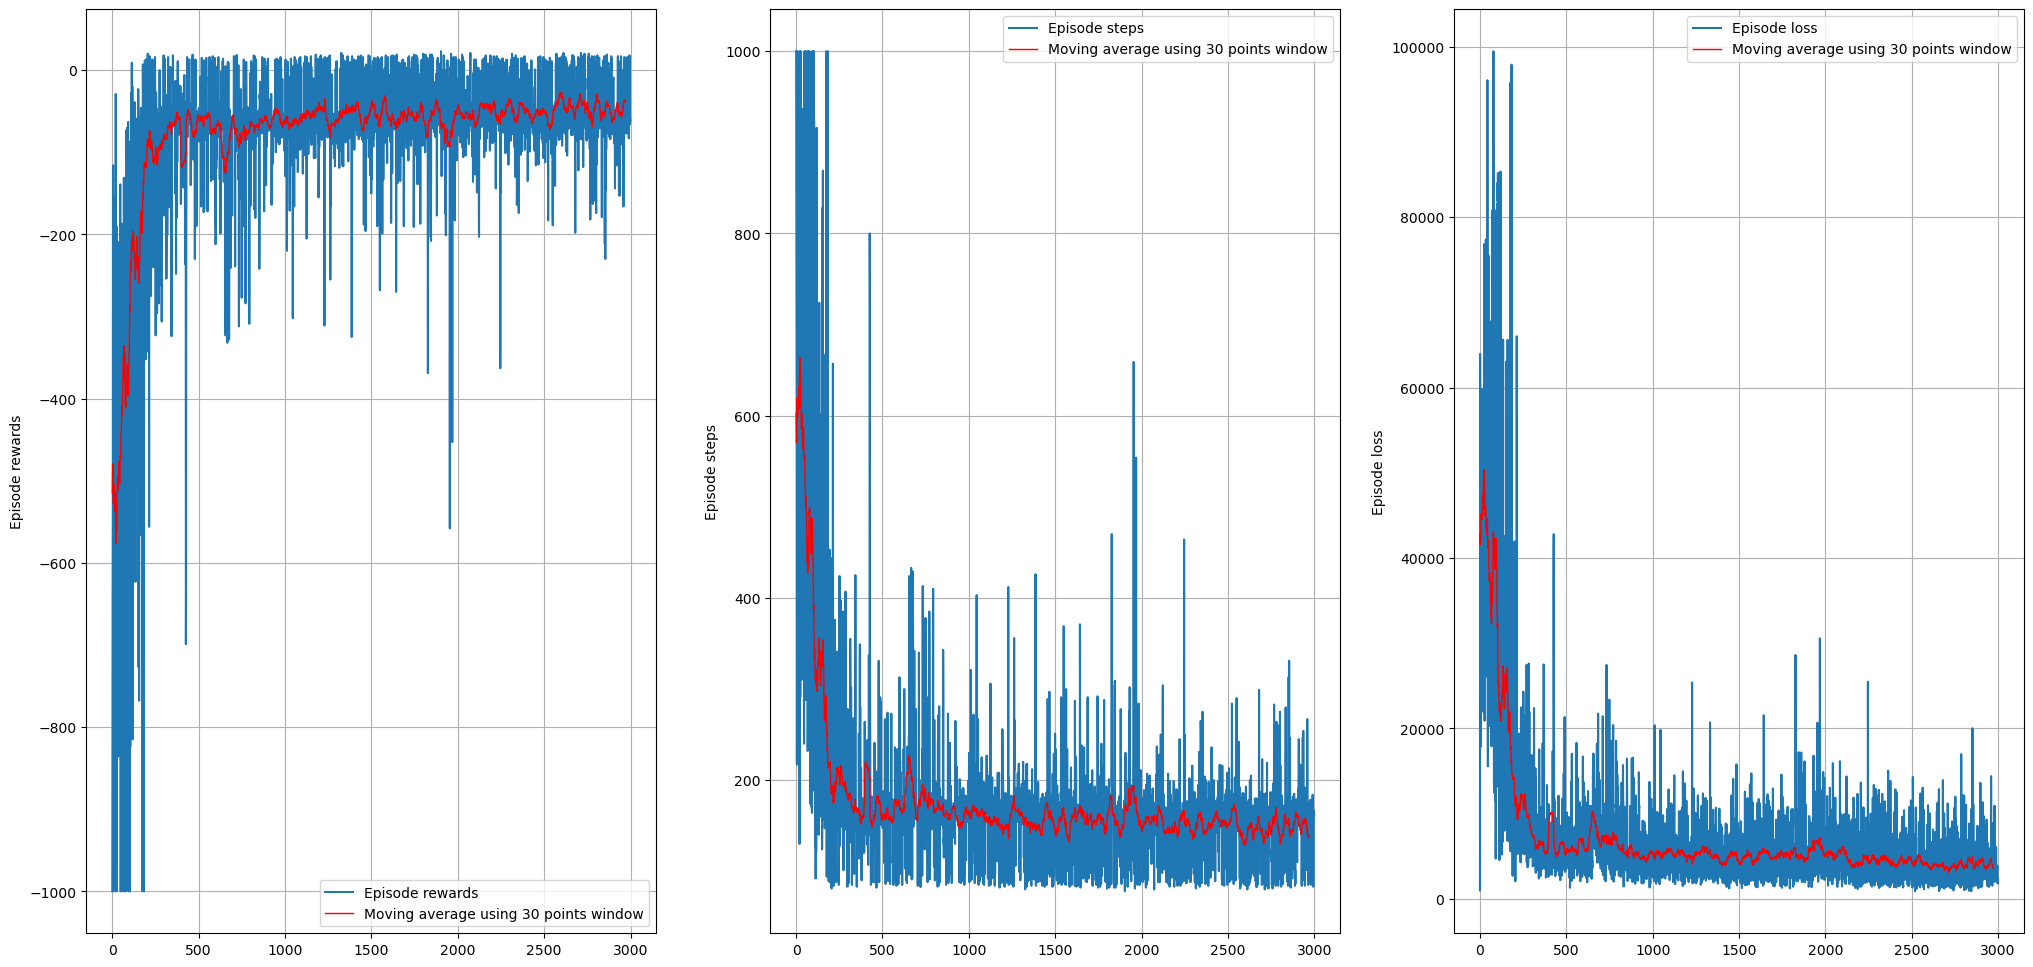

In [56]:
class MountainCar_Q_Model(torch.nn.Module):
    def __init__(self, env):
        super().__init__()

        self.ENV_STATE_SIZE = env.tiles + env.tiles
        self.ENV_ACTIONS = 3

        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE + self.ENV_ACTIONS, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
        )

    def forward(self, state, action):
        assert state.shape == (1, self.ENV_STATE_SIZE)
        assert action.shape == (1, 1)

        action_ohe = torch.nn.functional.one_hot(action.long(), num_classes=self.ENV_ACTIONS).float()
        action_ohe = action_ohe.view(action_ohe.shape[0], self.ENV_ACTIONS)

        inp = torch.cat([state, action_ohe], dim=1)

        q_val = self.model(inp)
        return q_val


@torch.no_grad()
def call_model_once(model, state, action):
    model.eval()

    q_val = model(
        state=torch.Tensor(state.reshape((1, -1))),
        action=torch.Tensor(np.array([action]).reshape((1, -1))),
    ).detach().cpu().numpy()[0, 0]

    return q_val

def train_once(model, state, action, target, optimizer, loss_fn):
    model.train()

    predicted_target = model(
        state=torch.Tensor(state.reshape((1, -1))),
        action=torch.Tensor(np.array([action]).reshape((1, -1))),
    )
    target = torch.Tensor(np.array([target]).reshape((1, -1)))

    loss = loss_fn(predicted_target, target)
    loss_item = loss.item()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    return loss_item

def get_action_epsilon_greedy(model, state, epsilon_greedy):
    if np.random.rand() <= epsilon_greedy:
        return np.random.randint(model.ENV_ACTIONS)

    best_action = max(range(model.ENV_ACTIONS), key=lambda action: call_model_once(model, state, action))

    return best_action

@torch.no_grad()
def eval(env, model, max_episodes, max_episode_steps):
    model.eval()

    rewards = []
    steps = []
    for episode_i in range(max_episodes):

        rewards.append(0)
        steps.append(0)

        state, info = env.reset()

        for step_i in range(max_episode_steps):

            action = get_action_epsilon_greedy(model, state, 0)

            state, reward, terminated, truncated, info = env.step(action)

            rewards[-1] += reward
            steps[-1] += 1

            if terminated or truncated:
                break

    print(f"Eval: episodes {max_episodes}, average episode sum rewards {np.mean(rewards)}, std {np.std(rewards)}. Average number of steps {np.mean(steps)}, std {np.std(steps)}")

def sarsa_impl(env, learning_rate, discount_factor, epsilon_greedy, max_episodes, max_episode_steps):
    model = MountainCar_Q_Model(env)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    train_curves = defaultdict(list)

    for episode_i in range(max_episodes):

        episode_reward = 0
        episode_steps = 0
        episode_loss = 0

        state, info = env.reset()
        action = get_action_epsilon_greedy(model, state, epsilon_greedy)

        for step_i in range(max_episode_steps):

            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_steps += 1

            if terminated:
                loss_val = train_once(model, state, action, reward, optimizer, loss_fn)
                episode_loss += loss_val
                break

            next_action = get_action_epsilon_greedy(model, next_state, epsilon_greedy)

            target = reward + discount_factor * call_model_once(model, next_state, next_action)

            loss_val = train_once(model, state, action, target, optimizer, loss_fn)
            episode_loss += loss_val

            state = next_state
            action = next_action

            if truncated:
                break

        train_curves['Episode rewards'].append(episode_reward)
        train_curves['Episode steps'].append(episode_steps)
        train_curves['Episode loss'].append(episode_loss)

    return model, train_curves

def show_train_curves(train_curves):
    fig, ax = plt.subplots(nrows=1, ncols=len(train_curves))
    fig.set_size_inches(25, 12)

    if len(train_curves) == 1:
        ax = [ax]

    for ci, (label, points) in enumerate(train_curves.items()):

        N = max(2, len(points) // 100)
        cumsum = np.cumsum(np.insert(points, 0, 0))
        moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

        ax[ci].plot(points, label=label)
        ax[ci].plot(moving_average, linewidth=1, color='r', label=f"Moving average using {N} points window")
        ax[ci].set_ylabel(label)
        ax[ci].legend()
        ax[ci].grid(True)

def solve_sarsa():
    env = MountainCarEnv(
        max_steps=1000,
        tiles=32,
        action_velocity=0.001,   # Book value: 0.001
        successful_finish_reward=100)

    model, train_curves = sarsa_impl(
        env=env,
        learning_rate=1e-3,
        discount_factor=0.999,
        epsilon_greedy=0.1,
        max_episodes=3000,
        max_episode_steps=1000)

    show_train_curves(train_curves)

    eval(
        env,
        model,
        max_episodes=100,
        max_episode_steps=1000)

    return env, model

env, model = solve_sarsa()

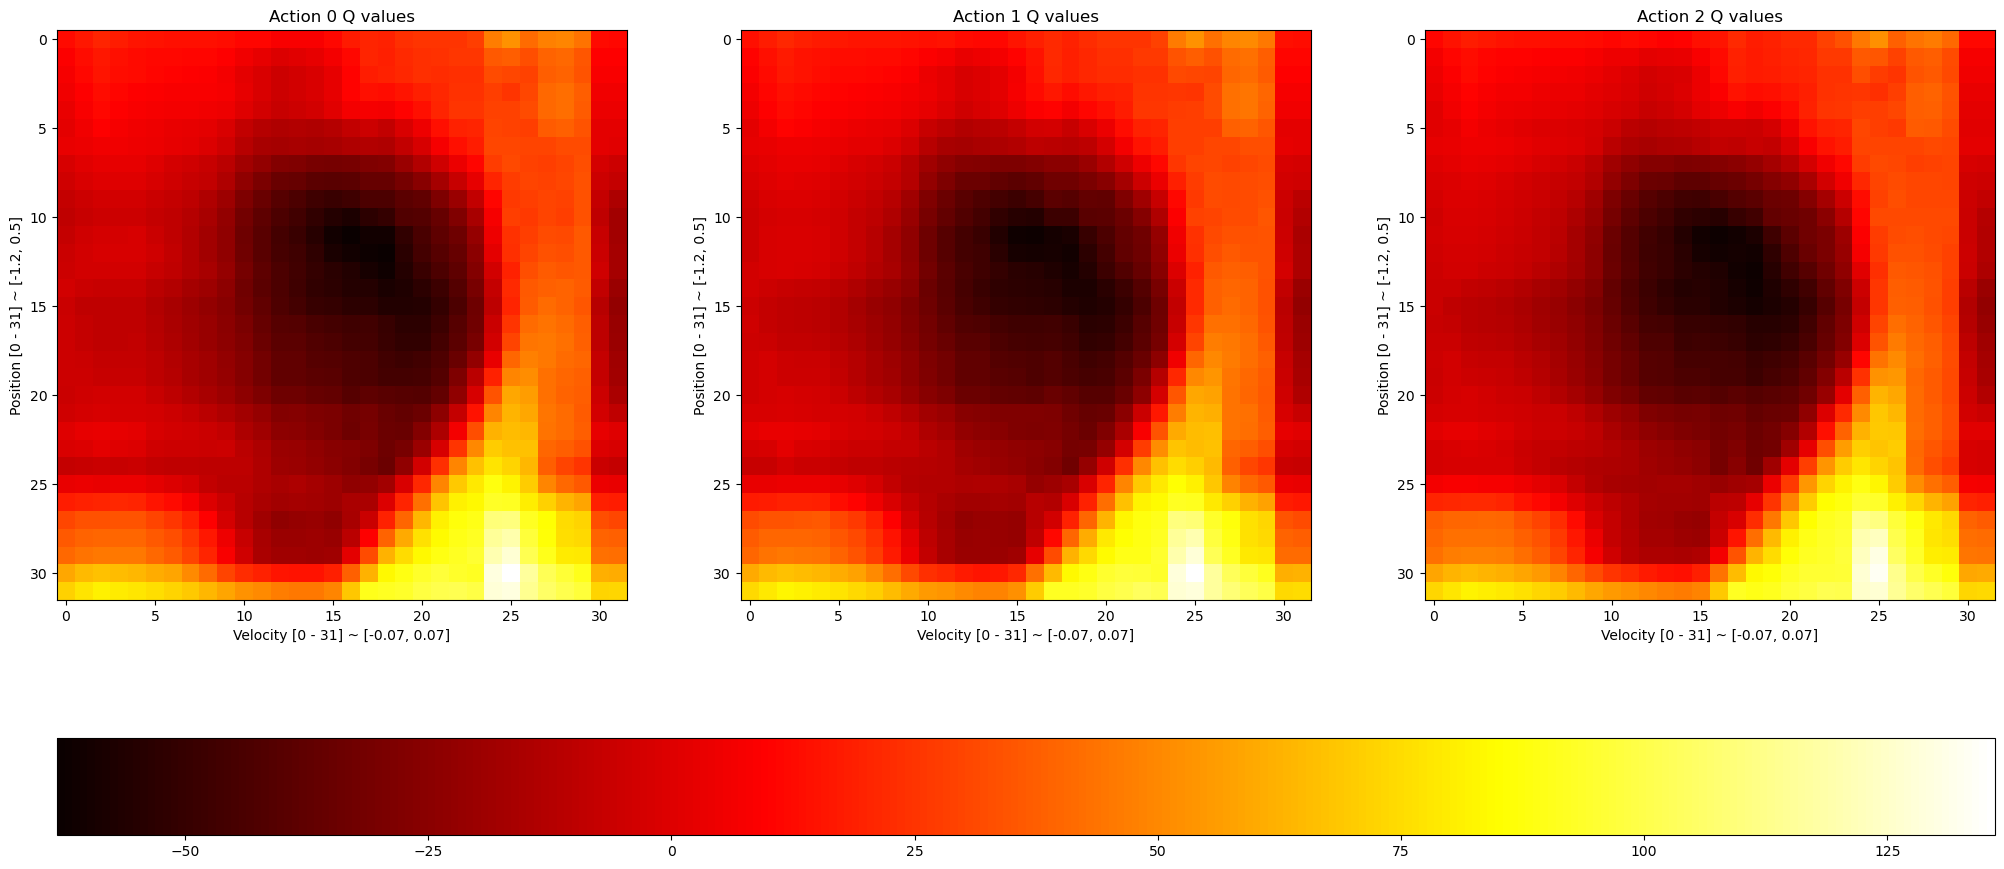

In [57]:
def show_q_values(model):
    q_values = np.zeros((3, env.tiles, env.tiles))
    for action, pos_i, vel_i in np.ndindex(q_values.shape):

        state = np.zeros((env.tiles + env.tiles), dtype=np.int32)
        state[pos_i] = 1
        state[env.tiles + vel_i] = 1

        q_val = call_model_once(model, state, action)

        q_values[action, pos_i, vel_i] = q_val

    vmin = np.min(q_values)
    vmax = np.max(q_values)

    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches(25, 12)

    for action in range(3):

        im = ax[action].imshow(q_values[action, :, :], cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[action].set_title(f"Action {action} Q values")
        ax[action].set_xlabel(f"Velocity [0 - {env.tiles - 1}] ~ {env.BOUNDARY_VEL}")
        ax[action].set_ylabel(f"Position [0 - {env.tiles - 1}] ~ {env.BOUNDARY_POS}")

    ax[-1].figure.colorbar(im, ax=ax, location='bottom')

show_q_values(model)

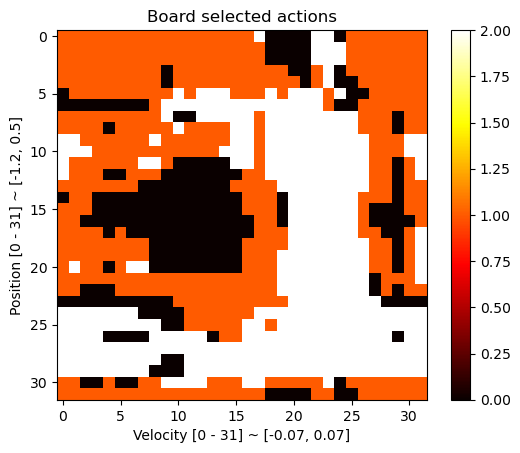

In [58]:
def show_actions(model):
    selected_actions = np.zeros((env.tiles, env.tiles))
    for pos_i, vel_i in np.ndindex(selected_actions.shape):
        state = np.zeros((env.tiles + env.tiles), dtype=np.int32)
        state[pos_i] = 1
        state[env.tiles + vel_i] = 1

        best_action = max(range(model.ENV_ACTIONS), key=lambda action: call_model_once(model, state, action))

        selected_actions[pos_i, vel_i] = best_action

    im = plt.imshow(selected_actions, cmap='hot', interpolation='nearest', vmin=0, vmax=2)
    plt.title(f"Board selected actions")
    plt.colorbar(im)
    plt.xlabel(f"Velocity [0 - {env.tiles - 1}] ~ {env.BOUNDARY_VEL}")
    plt.ylabel(f"Position [0 - {env.tiles - 1}] ~ {env.BOUNDARY_POS}")

show_actions(model)